In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
from gradboost_pv.models.pretrained import load_local_preprocessed_slice, build_datasets_from_local
from gradboost_pv.models.common import NWP_FPATH, GSP_FPATH

gsp = xr.open_zarr(GSP_FPATH)
nwp = xr.open_zarr(NWP_FPATH)

evaluation_timeseries = gsp.coords["datetime_gmt"].where(
        (gsp["datetime_gmt"] >= nwp.coords["init_time"].values[0]) & (gsp["datetime_gmt"] <= nwp.coords["init_time"].values[-1]), 
        drop=True).values

gsp = gsp.sel(datetime_gmt = evaluation_timeseries, gsp_id=0)

In [3]:
X = load_local_preprocessed_slice(20)
X, y = build_datasets_from_local(X, gsp, nwp.coords["step"].values[20], False)
X.head()  # for each nwp variable, there are 4 buckets, downsampling the 1_000 output dim of the pretrained model.

,cdcb_0,cdcb_1,cdcb_2,cdcb_3,cdcb_4,lcc_0,lcc_1,lcc_2,lcc_3,lcc_4,...,prate_4,SIN_MONTH,COS_MONTH,SIN_DAY,COS_DAY,SIN_HOUR,COS_HOUR,PV_LAG_1HR,PV_LAG_DAY,LR_Beta
2020-01-02 00:00:00,0.015929,0.299109,0.003977,0.001697,0.001229,0.000002,0.000125,0.009623,0.683088,0.007255,...,0.159401,0.5,0.866025,0.034328,0.999411,-0.866025,0.500000,0.0,0.0,0.124602
2020-01-02 00:30:00,0.021710,0.255703,0.010125,0.004732,0.002839,0.000002,0.000120,0.009539,0.682957,0.007188,...,0.154181,0.5,0.866025,0.034328,0.999411,-0.793353,0.608761,0.0,0.0,0.050805
2020-01-02 01:00:00,0.027491,0.212298,0.016274,0.007766,0.004448,0.000002,0.000114,0.009454,0.682827,0.007120,...,0.148962,0.5,0.866025,0.034328,0.999411,-0.707107,0.707107,0.0,0.0,0.011746
2020-01-02 01:30:00,0.033272,0.168892,0.022423,0.010801,0.006057,0.000002,0.000109,0.009370,0.682697,0.007053,...,0.143742,0.5,0.866025,0.034328,0.999411,-0.608761,0.793353,0.0,0.0,0.000555
2020-01-02 02:00:00,0.039053,0.125486,0.028571,0.013835,0.007666,0.000002,0.000104,0.009286,0.682566,0.006985,...,0.138522,0.5,0.866025,0.034328,0.999411,-0.500000,0.866025,0.0,0.0,0.000003


#### Experiment 1
Fit a model directly with 4 covariates per nwp variable, taken directly from downsampling the pretrained model output.

In [4]:
from gradboost_pv.models.experiment import run_experiment, plot_feature_importances, plot_loss_metrics

LOCAL_SAVE_DIR = "/home/tom/local_data/nationalpv_model_errors/pretrained_full.pkl"
results = dict()

for step in range(0, 36):
    # can't really multiprocess this since the xgb training maxes out the cores anyway
    X = load_local_preprocessed_slice(step)
    X, y = build_datasets_from_local(X, gsp, nwp.coords["step"].values[step], summarize_buckets=False)
    output = run_experiment(X, y, save_errors_locally=True, errors_local_save_file=LOCAL_SAVE_DIR)
    results[step] = output
    print(f"Completed run for step {step}")

Completed run for step 0
Completed run for step 1


/home/tom/dev/gradboost_pv/gradboost_pv/models/common.py:100: RuntimeWarning: invalid value encountered in multiply
  betas = np.nan * np.empty(len(y))


Completed run for step 2
Completed run for step 3
Completed run for step 4
Completed run for step 5
Completed run for step 6
Completed run for step 7
Completed run for step 8
Completed run for step 9
Completed run for step 10
Completed run for step 11
Completed run for step 12
Completed run for step 13
Completed run for step 14
Completed run for step 15
Completed run for step 16
Completed run for step 17
Completed run for step 18
Completed run for step 19
Completed run for step 20
Completed run for step 21
Completed run for step 22
Completed run for step 23
Completed run for step 24
Completed run for step 25
Completed run for step 26
Completed run for step 27
Completed run for step 28
Completed run for step 29
Completed run for step 30
Completed run for step 31
Completed run for step 32
Completed run for step 33
Completed run for step 34
Completed run for step 35


In [3]:
from gradboost_pv.models.experiment import run_experiment, plot_feature_importances, plot_loss_metrics

step = 15

X = load_local_preprocessed_slice(step)
X, y = build_datasets_from_local(X, gsp, nwp.coords["step"].values[step], summarize_buckets=False)
y_test, y_pred_test = run_experiment(X, y, save_errors_locally=False)

In [4]:
y_test

,target
2021-01-01 00:00:00,0.035419
2021-01-01 00:30:00,0.013059
2021-01-01 01:00:00,0.002159
2021-01-01 01:30:00,0.000000
2021-01-01 02:00:00,0.000000
...,...
2021-11-07 22:00:00,0.191085
2021-11-07 22:30:00,0.159681
2021-11-07 23:00:00,0.144202
2021-11-07 23:30:00,0.093407


In [5]:
y_pred_test

array([0.03528191, 0.01629826, 0.00567465, ..., 0.18011725, 0.14157093,
       0.08799209], dtype=float32)

In [6]:
errors_test = pd.DataFrame(
            data=np.concatenate(
                [
                    (y_test.values - y_pred_test) ** 2,
                    np.abs(y_test.values - y_pred_test),
                ],
                axis=1,
            ),
            columns=["test_mse", "test_mae"],
            index=y_test.index,
        )

ValueError: Shape of passed values is (14914, 29828), indices imply (14914, 2)

In [10]:
y_pred_test.shape

(14914,)

In [13]:
y_test.values.shape

(14914, 1)

In [15]:
((y_test.values - y_pred_test.reshape(-1, 1)) ** 2).shape

(14914, 1)

In [17]:
np.abs(y_test.values - y_pred_test.reshape(-1, 1)).shape

(14914, 1)

In [1]:
import numpy as np
import xarray as xr
from torchdata.datapipes import functional_datapipe
from torchdata.datapipes.iter import IterDataPipe
import torch
import pickle
from torchvision.models import resnet101
from ocf_datapipes.load.nwp.nwp import OpenNWPIterDataPipe
import pandas as pd
import matplotlib.pyplot as plt

from pandas.core.dtypes.common import is_datetime64_dtype
import numpy.typing as npt
from typing import Union, Tuple

/home/tom/mambaforge/envs/xg_pv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tom/mambaforge/envs/xg_pv/lib/python3.10/site-packages/nowcasting_datamodel/models/forecast.py:196: SAWarning: This declarative base already contains a class with the same class name and module name as nowcasting_datamodel.models.forecast.ForecastValueYearMonth, and will be replaced in the string-lookup table.
  class ForecastValueYearMonth(ForecastValueSQLMixin, Base_Forecast):


Unable to import PVLive utils, please provide filenames with OpenGSP
Unable to import PVLive utils, please provide filenames with OpenGSP


In [2]:
nwp_path = "gs://solar-pv-nowcasting-data/NWP/UK_Met_Office/UKV_intermediate_version_3.zarr/"
gsp_path = "gs://solar-pv-nowcasting-data/PV/GSP/v5/pv_gsp.zarr"
gsp = xr.open_zarr(gsp_path)
nwp = xr.open_zarr(nwp_path)

evaluation_timeseries = gsp.coords["datetime_gmt"].where(
        (gsp["datetime_gmt"] >= nwp.coords["init_time"].values[0]) & (gsp["datetime_gmt"] <= nwp.coords["init_time"].values[-1]), 
        drop=True).values

gsp = gsp.sel(datetime_gmt = evaluation_timeseries, gsp_id=0)

In [10]:
TRIG_DATETIME_FEATURE_NAMES = ["SIN_MONTH", "COS_MONTH", "SIN_DAY", "COS_DAY", "SIN_HOUR", "COS_HOUR"]

def _get_path_to_pretrained_data(forecast_horizon: int) -> str:
    return f"/home/tom/local_data/pretrained_nwp_processing_step_{forecast_horizon}.pkl"


def _trig_transform(values: np.ndarray, period: Union[float, int]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Given a list of values and an upper limit on the values, compute trig decomposition.
    Args:
        values: ndarray of points in the range [0, period]
        period: period of the data
    Returns:
        Decomposition of values into sine and cosine of data with given period
    """

    return np.sin(values * 2 * np.pi / period), np.cos(values * 2 * np.pi / period)


def trigonometric_datetime_transformation(datetimes: npt.ArrayLike) -> np.ndarray:
    """
    Given an iterable of datetimes, returns a trigonometric decomposition on hour, day and month
    Args:init_time=30,
        datetimes: ArrayLike of datetime64 values
    Returns:
        Trigonometric decomposition of datetime into hourly, daily and
        monthly values.
    """
    assert is_datetime64_dtype(datetimes), "Data for Trig Decomposition must be np.datetime64 type"

    datetimes = pd.DatetimeIndex(datetimes)
    hour = datetimes.hour.values.reshape(-1, 1) + (datetimes.minute.values.reshape(-1, 1) / 60)
    day = datetimes.day.values.reshape(-1, 1)
    month = datetimes.month.values.reshape(-1, 1)

    sine_hour, cosine_hour = _trig_transform(hour, 24)
    sine_day, cosine_day = _trig_transform(day, 366)
    sine_month, cosine_month = _trig_transform(month, 12)

    return np.concatenate(
        [sine_month, cosine_month, sine_day, cosine_day, sine_hour, cosine_hour], axis=1
    )



def build_datasets_from_local(step: int, nan_to_zero: bool = False) -> Tuple[pd.DataFrame, pd.DataFrame]:
    X = pd.read_pickle(_get_path_to_pretrained_data(step))
    
    # group by variable, calculate mean and std among the 4 quadrants
    # 4 quadrants themselves is too noisy
    X.columns = X.columns.str.split("_").str[0]
    group_var = X.groupby(level=0, axis=1)
    mean = group_var.mean(numeric_only=True)
    mean.columns = [f"{col}_mean" for col in mean.columns]
    std = group_var.std(numeric_only=True)
    std.columns = [f"{col}_std" for col in mean.columns]
    
    X = pd.concat([mean, std], axis=1)
    y = pd.DataFrame(gsp["generation_mw"] / gsp["installedcapacity_mwp"], index=evaluation_timeseries, columns=["target"])
    
    # shift y by the step forecast
    shift = nwp.step.values[step]
    y = y.shift(freq=-shift).dropna()
    common_index=sorted(pd.DatetimeIndex((set(y.index).intersection(X.index))))
    
    X, y = X.loc[common_index], y.loc[common_index]
    
    # add datetime methods for the point at which we are forecasting e.g. now + step
    _X = trigonometric_datetime_transformation(y.shift(freq=nwp.step.values[step]).index.values)
    _X = pd.DataFrame(_X, index=y.index, columns=TRIG_DATETIME_FEATURE_NAMES)
    X = pd.concat([X, _X], axis=1)
    
    # add lagged values of GSP PV
    ar_1 = y.shift(freq = -(shift + np.timedelta64(1, "h")))
    ar_day = y.shift(freq = - (shift + np.timedelta64(1, "D")))
    ar_1.columns = ["PV_LAG_1HR"]
    ar_day.columns = ["PV_LAG_DAY"]
    
    # estimate linear trend of the PV
    window_size = 10
    epsilon = 0.01
    y_covariates = y.shift(freq = -(shift + np.timedelta64(2, "h")))
    y_covariates.columns = ["x"]
    y_target = y.shift(freq = -(shift + np.timedelta64(1, "h")))
    y_target.columns = ["y"]
    data = pd.concat([y_target, y_covariates], axis=1).dropna()
    _x = data["x"].values
    _y = data["y"].values
    _betas = np.nan * np.empty(len(data))
    
    for n in range(window_size, len(data)):
        __y = _y[(n-window_size): n]
        __x = _x[(n-window_size): n]
        __b = max(min((1 / ((__x.T @ __x) + epsilon))  * (__x.T @ __y), 10), -10)
        _betas[n] = __b
    
    betas = pd.DataFrame(data=_betas, columns=["AR_Beta"], index=data.index)
    
    X = pd.concat([X, ar_1, ar_day, betas], axis=1).dropna()
    y = y.loc[X.index]
    
    
    return X, y

In [48]:
# lets do another grid search for a model under this data.
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

param_grid = {
    "colsample_bytree" : [0.6, 0.9],
    "grow_policy": ["depthwise", "leafwise"],
    "learning_rate" : [0.005, 0.001],
    "min_child_weight": [5, 25],
    "max_depth": [50, 200],
    "n_estimators": [800, 2_000],
    # "reg_alpha": [0, 5],
    # "reg_lambda": [1, 5],
    "subsample": [0.65, 0.9]
}

gsearch = GridSearchCV(XGBRegressor(), param_grid, scoring="neg_mean_absolute_error", verbose=1, cv=3, n_jobs=-1)

In [49]:
results = gsearch.fit(X, y)

Fitting 3 folds for each of 128 candidates, totalling 384 fits


KeyboardInterrupt: 

In [11]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from dataclasses import dataclass

DEFFAULT_HYPARAM_CONFIG = {
               'objective': 'reg:squarederror',
               'booster': 'gbtree',
               'colsample_bylevel': 1,
               'colsample_bynode': 1,
               'colsample_bytree': 0.85,
               'early_stopping_rounds': None,
               'gamma': 0,
               'gpu_id': -1,
               'grow_policy': 'depthwise',
               'importance_type': None,
               'interaction_constraints': '',
               'learning_rate': 0.005,
               'max_bin': 256,
               'max_cat_threshold': 64,
               'max_depth': 100,
               'max_leaves': 0,
               'min_child_weight': 5,
               'n_estimators': 1_500,
               'n_jobs': -1,
               'num_parallel_tree': 1,
               'predictor': 'auto',
               'random_state': 0,
               'reg_alpha': 0,
               'reg_lambda': 1,
               'sampling_method': 'uniform',
               'scale_pos_weight': 1,
               'subsample': 0.65,
               'tree_method': 'hist',
               'validate_parameters': 1,
               'verbosity': 1
 }


@dataclass
class ExperimentSummary:
    mse_train_loss: float
    mse_test_loss: float
    mae_train_loss: float
    mae_test_loss: float
    model: XGBRegressor



def run_experiment(X: pd.DataFrame,
                   y: pd.DataFrame,
                   booster_hyperparam_config: dict = DEFFAULT_HYPARAM_CONFIG
                   ) -> ExperimentSummary:

    # use 2020 as training period and 2021 as test
    X_train, y_train = X.loc[X.index < "2021-01-01"], y.loc[y.index < "2021-01-01"]
    X_test, y_test = X.loc[X.index >= "2021-01-01"], y.loc[y.index >= "2021-01-01"]

    model = XGBRegressor(**booster_hyperparam_config)
    model.fit(X_train, y_train)
    
    y_pred_test, y_pred_train = model.predict(X_test), model.predict(X_train)
    train_mse, test_mse = mean_squared_error(y_train, y_pred_train), mean_squared_error(y_test, y_pred_test)
    train_mae, test_mae = mean_absolute_error(y_train, y_pred_train), mean_absolute_error(y_test, y_pred_test)
        
    
    return ExperimentSummary(
        train_mse,
        test_mse,
        train_mae,
        test_mae,
        model  # just save the last trained model for nwp
    )
        

In [12]:
results = dict()

for step in range(0, 36):
    # can't really multiprocess this since the xgb training maxes out the cores anyway
    X, y = build_datasets_from_local(step)
    output = run_experiment(X, y)
    results[step] = output
    print(f"Completed run for step {step}")

Completed run for step 0
Completed run for step 1
Completed run for step 2
Completed run for step 3
Completed run for step 4
Completed run for step 5
Completed run for step 6
Completed run for step 7
Completed run for step 8
Completed run for step 9
Completed run for step 10
Completed run for step 11
Completed run for step 12
Completed run for step 13
Completed run for step 14
Completed run for step 15
Completed run for step 16
Completed run for step 17
Completed run for step 18
Completed run for step 19
Completed run for step 20
Completed run for step 21
Completed run for step 22
Completed run for step 23
Completed run for step 24
Completed run for step 25
Completed run for step 26
Completed run for step 27
Completed run for step 28
Completed run for step 29
Completed run for step 30
Completed run for step 31
Completed run for step 32
Completed run for step 33
Completed run for step 34
Completed run for step 35


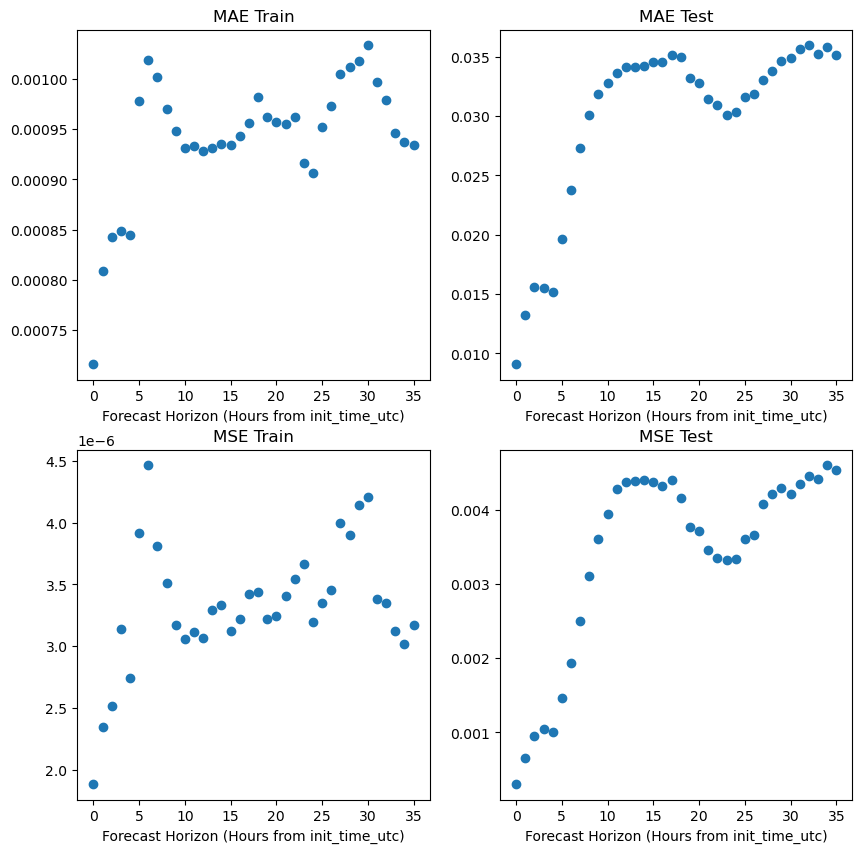

In [13]:
# plot the MAE of the OOS for each model
from typing import Dict

def plot_loss_metrics(results_by_fh: Dict[int, ExperimentSummary]):
    title_mapping = {"MAE Train": lambda x: x.mae_train_loss,
                     "MAE Test": lambda x: x.mae_test_loss,
                     "MSE Train": lambda x: x.mse_train_loss,
                     "MSE Test": lambda x: x.mse_test_loss}
    
    fig, axes = plt.subplots(2,2, figsize=(10, 10))
    
    for idx, title in enumerate(title_mapping.keys()):
        row = int(idx > 1)
        col = idx % 2
        data = pd.Series({step: title_mapping[title](r) for step, r in results_by_fh.items()})
        axes[row][col].scatter(data.index, data.values)
        axes[row][col].set_title(title)
        axes[row][col].set_xlabel("Forecast Horizon (Hours from init_time_utc)")

plot_loss_metrics(results)

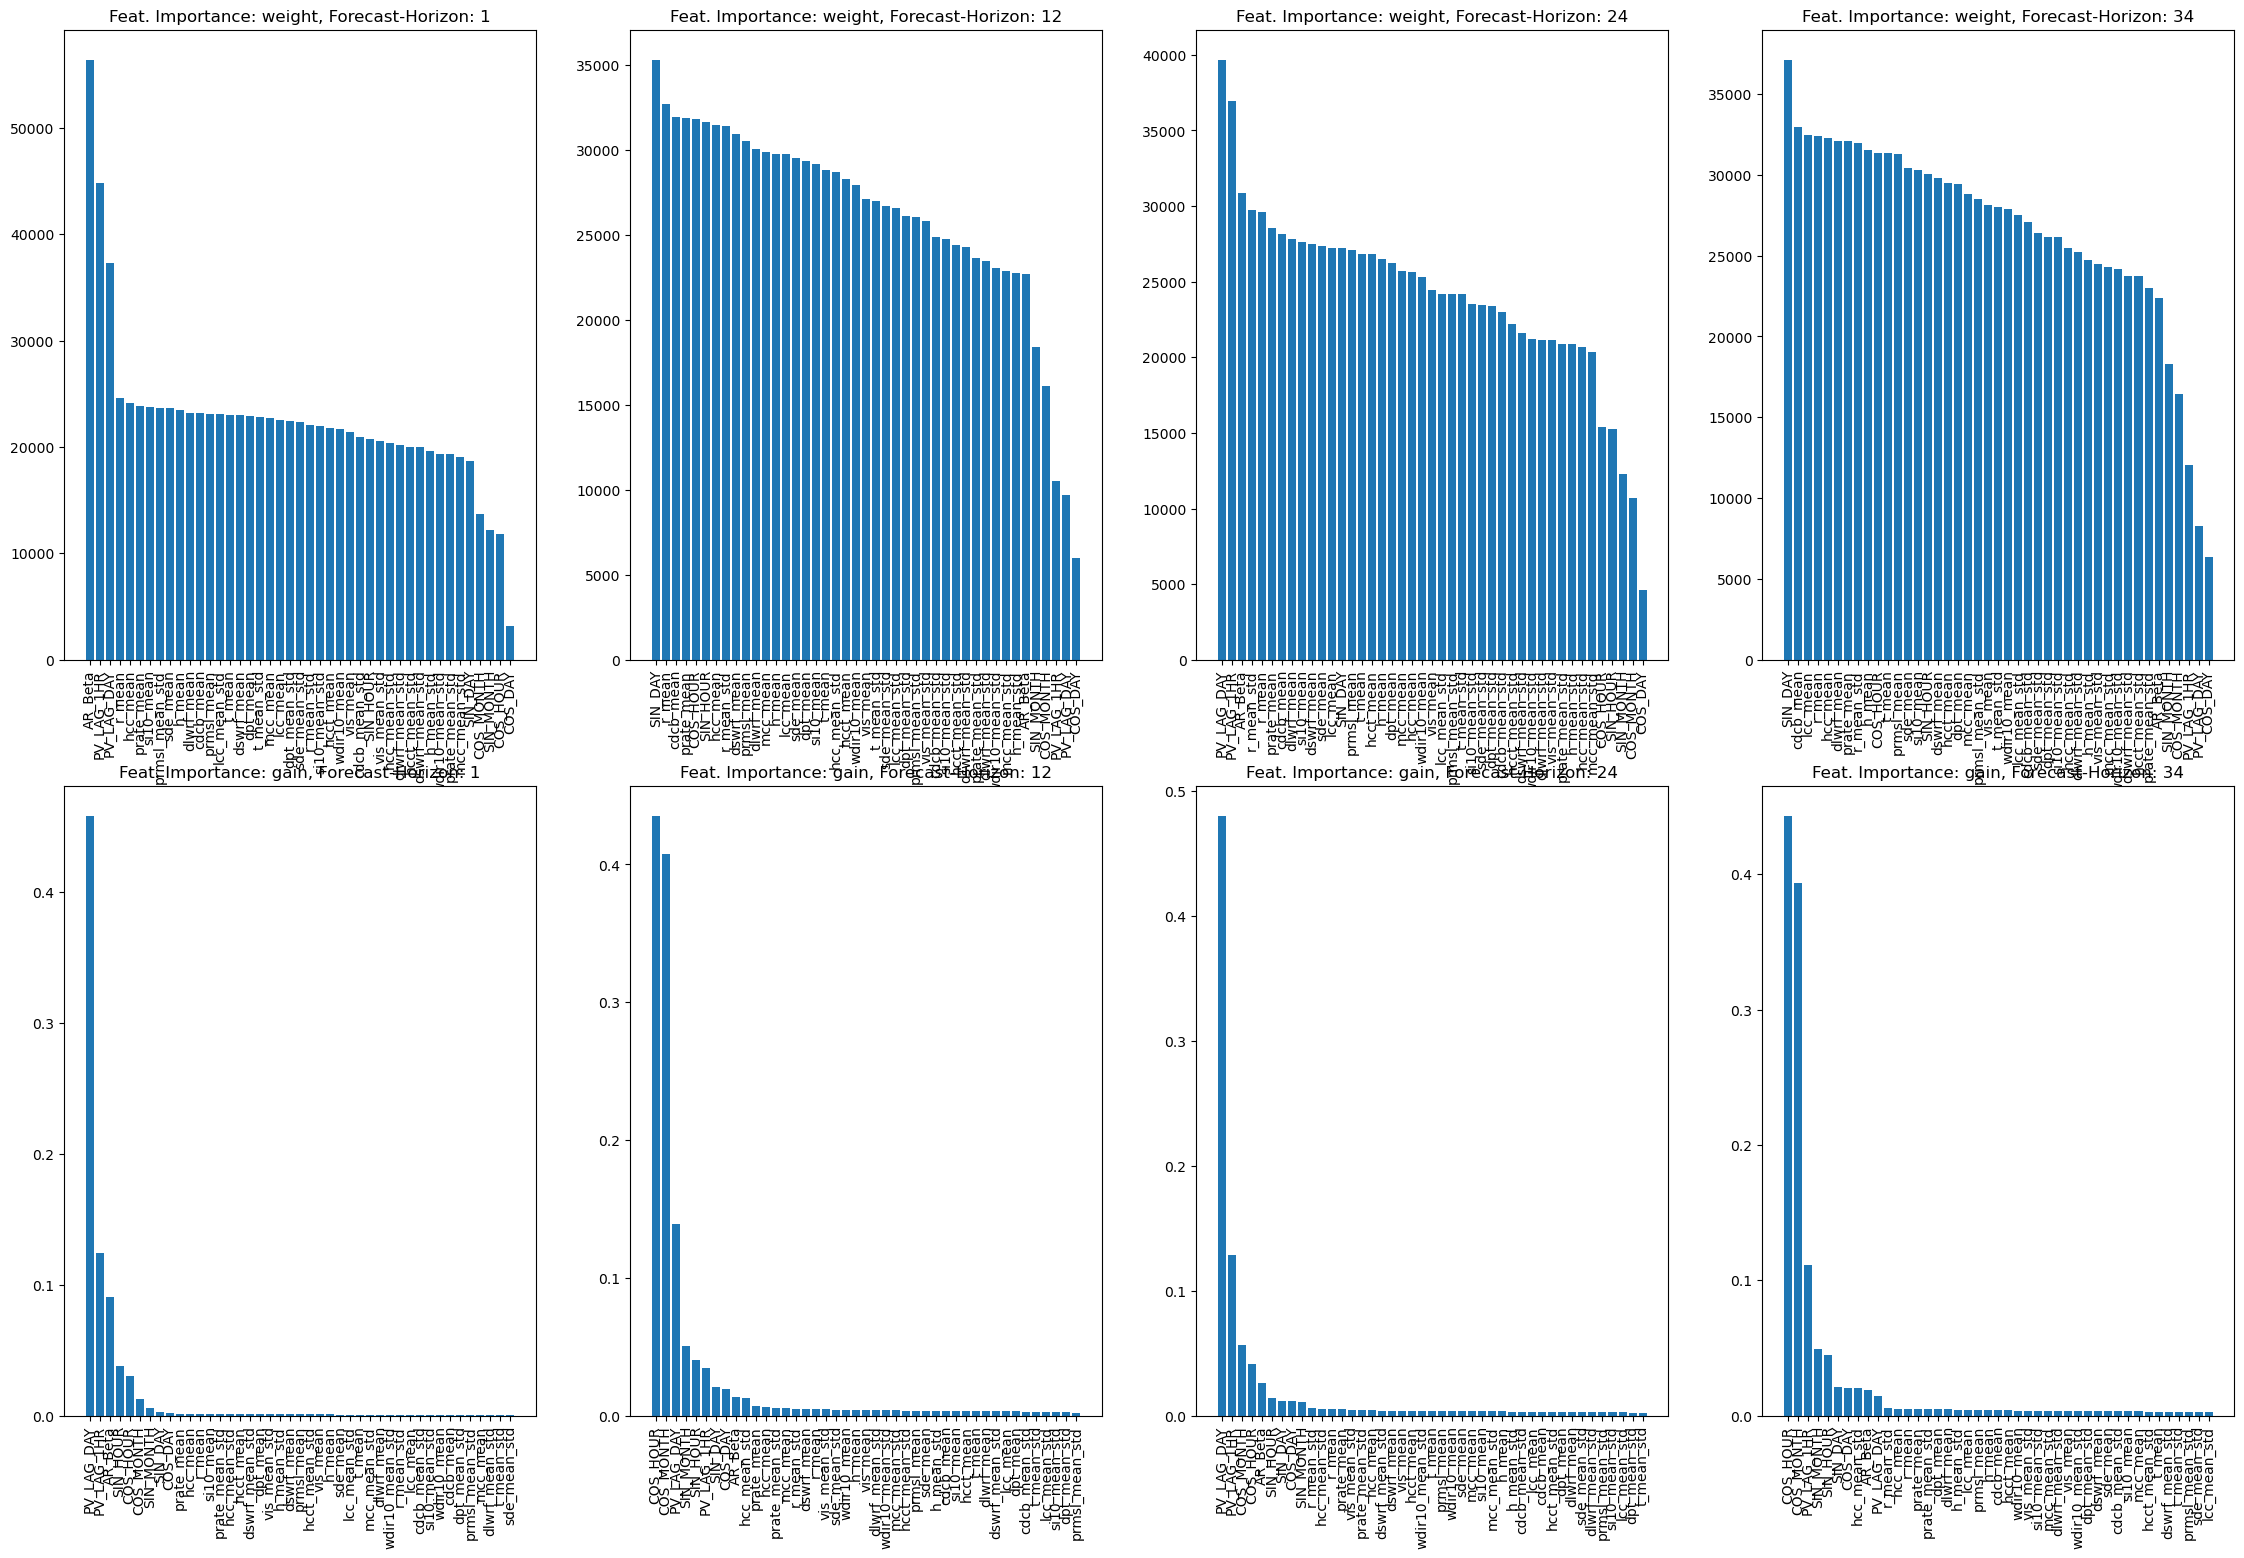

In [14]:
def plot_feature_importances(results_by_fh: Dict[int, ExperimentSummary], forecast_horizons = [1, 12, 24, 34]):
    assert len(forecast_horizons) == 4, "Plotting built for 4 forecast horizons!!"
    fig, axes = plt.subplots(2, 4, figsize=(28, 18))
    
    for param_idx, param in enumerate(["weight", "gain"]):
        for idx, fh in enumerate(forecast_horizons):
            data = pd.DataFrame.from_dict(results_by_fh[fh].model.get_booster().get_score(importance_type=param), orient="index").sort_values(by=0, ascending=False)
            axes[param_idx][idx].bar(range(len(data)), data.values.flatten())#, tick_label=data.index)
            axes[param_idx][idx].set_xticks(range(len(data)))
            axes[param_idx][idx].set_xticklabels(data.index, rotation=90)
            axes[param_idx][idx].set_title(f"Feat. Importance: {param}, Forecast-Horizon: {fh}")
            
        

test = plot_feature_importances(results)

### Comment:

Underperforms basic model. Similarly to the quadrant model, our NWP features are not as important as other generated features, unlike the case with the base model. This approach does not seem very promising. For now, move onto the uk-region masked features. 

It should be noted that there is a large gap between out is and oos errors, so we will likely need to return to grid-search for further hyperparameter tuning in later models.